In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import torch
import torch.nn as nn 

# necessary for reading the data
import glob
import pandas as pd 

## Download data

You need to first have a kaggle account and obtain key. Store in ~/.kaggle/kaggle.json  
https://github.com/Kaggle/kaggle-api

In [ ]:
# install kaggle api
#!pip3 install --no-cache-dir kaggle

In [6]:
# View files of galaxy zoo competition
!kaggle competitions files -c galaxy-zoo-the-galaxy-challenge

name                          size  creationDate         
---------------------------  -----  -------------------  
training_solutions_rev1.zip    5MB  2018-06-20 07:34:13  
all_zeros_benchmark.zip      265KB  2018-06-20 07:34:13  
images_test_rev1.zip           1GB  2018-06-20 07:34:13  
central_pixel_benchmark.zip  520KB  2018-06-20 07:34:13  
images_training_rev1.zip     792MB  2018-06-20 07:34:13  
all_ones_benchmark.zip       265KB  2018-06-20 07:34:13  


In [7]:
root_save = r'/home/foivos/Projects/dl_workshop_2020/GalaxyZoo/data' 

In [8]:
# Download only the training files 
!kaggle competitions download  galaxy-zoo-the-galaxy-challenge -f training_solutions_rev1.zip -p $root_save
!kaggle competitions download  galaxy-zoo-the-galaxy-challenge -f images_training_rev1.zip -p $root_save

100%|██████████████████████████████████████| 4.63M/4.63M [00:00<00:00, 6.44MB/s]
100%|██████████████████████████████████████| 4.63M/4.63M [00:00<00:00, 7.61MB/s]
100%|███████████████████████████████████████▉| 791M/792M [01:23<00:00, 9.17MB/s]
100%|████████████████████████████████████████| 792M/792M [01:23<00:00, 9.91MB/s]


In [9]:
import os
imgs_zipped = os.path.join(root_save,r'images_training_rev1.zip')
csv_zipped = os.path.join(root_save,r'training_solutions_rev1.zip')

In [10]:
# unzip the images 
!unzip -q $imgs_zipped -d $root_save
!unzip -q $csv_zipped -d $root_save 

In [11]:
ls $root_save

images_training_rev1/     training_solutions_rev1.csv
images_training_rev1.zip  training_solutions_rev1.zip
readme.txt


In [3]:
#root = r'/Users/foivos/Documents/kaggle_comps/GalaxyZoo/data/' 

In [12]:
root_imgs = os.path.join(root_save , r'images_training_rev1/')
flnames_imgs = sorted(glob.glob(root_imgs+'*.jpg'))

In [13]:
len(flnames_imgs)

61578

In [22]:
# It'll take a while, depending on your computer ...
# Estimated values means, stds, (from all data): 
# array([11.663384, 10.260227,  7.65015 ], dtype=float32)
# array([21.421959, 18.044296, 15.494861], dtype=float32)

# Discuss train/test/split, and when to use train data only (or not) for means/stds. 

# means = []
# stds = []
# for name in flnames_imgs:
#     img = imread(name).transpose([2,0,1]).astype(np.float32)
#     m = img.mean(axis=(1,2),keepdims=True)
#     c = img - m
#     std = np.mean(c**2,axis=(1,2))**0.5
    
#     means += [m]
#     stds +=  [std]
# means = np.array(means).squeeze()
# stds = np.array(stds).squeeze()    

In [14]:
dataset = pd.read_csv(os.path.join(root_save,r'training_solutions_rev1.csv'),sep=",")
dataset = dataset.sort_values(by='GalaxyID') # be on the save side 

In [15]:
dataset.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


### Create a FIXED split of training/validation/test - avoids data leakage

In [16]:
# Shuffle the data
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Estimate an 80-10-10 train/dev/test split 
train_ids = dataset.GalaxyID.iloc[:int(len(dataset)*0.8)].reset_index(drop=True)
dev_ids = dataset.GalaxyID.iloc[int(len(dataset)*0.8):int(len(dataset)*0.9)].reset_index(drop=True)
test_ids = dataset.GalaxyID.iloc[int(len(dataset)*0.9):].reset_index(drop=True)

# Store data into csv files - FIX your split to avoid data leakage. 
train_ids.to_csv(os.path.join(root_save,r'train_indices.csv'),index=False)
dev_ids.to_csv(os.path.join(root_save, r'dev_indices.csv'),index=False)
test_ids.to_csv(os.path.join(root_save, r'test_indices.csv'),index=False)

## Some visualizations of the data augmentation, in order to understand the effect of it

In [26]:
# not necessary, but keep it for reference 
# class GZooNormal(object):
#     def __init__(self):
#         self.means = np.array([11.663384, 10.260227,  7.65015 ],dtype=np.float32)
#         self.stds = np.array([21.421959, 18.044296, 15.494861], dtype=np.float32)
                  
#     def __call__(self,img):
        
#         temp = img.astype(np.float32)
#         temp2 = temp.T
#         temp2 -= self._mean
#         temp2 /= self._std

#         temp = temp2.T

#         return temp

    
#     def restore(self,normed_img):
#         # Useful for visualization purposes
#         d2 = normed_img.T * self._std
#         d2 = d2 + self._mean
#         d2 = d2.T
#         d2 = np.round(d2)
#         d2 = d2.astype('uint8')

#         return d2


In [27]:
# This is not the most efficient way of using the data, see mxnet recio for better 

from PIL import Image
class GZooData(torch.utils.data.Dataset):
    def __init__(self, root = r'/Users/foivos/Documents/kaggle_comps/GalaxyZoo/data/',mode = 'train',  transform=None):
        
        self._transform = transform
               
        self.root_imgs = root + r'images_training_rev1/'
        self.df = pd.read_csv(root + r'training_solutions_rev1.csv',sep=",")
 
        if mode=='train':
            self.idxs = pd.read_csv(root + r'train_indices.csv')
        elif mode =='dev':
            self.idxs = pd.read_csv(root + r'dev_indices.csv')
        elif mode == 'test':
            self.idxs = pd.read_csv(root + r'test_indices.csv')
        else:
            raise ValueError("I do not understand given mode::{}, aborting ...".format(mode))
            
        # Get the FIXED split 
        self.df = self.df[self.df.GalaxyID.isin(self.idxs.GalaxyID)]
        
    def __getitem__(self, idx):
        
        GID = int(self.df.iloc[idx]['GalaxyID'])
        probs = self.df.iloc[idx,1:].to_numpy()
        
        path_read = self.root_imgs + str(GID) +r'.jpg'
        
        #img = imread(path_read).astype(np.float32)
        img = Image.open(path_read)
        #img = img/255.
        #img = img.transpose([2,0,1])
        
        if self._transform is not None:
            img = self._transform(img)

        return img, probs     
    
    def __len__(self):
        return len(self.df)
        

In [108]:
dataset.df

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


41223 (3, 424, 424)


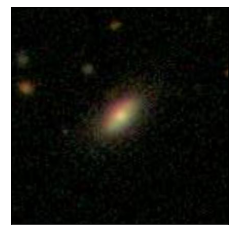

In [44]:
import torchvision 
dataset = GZooData()
# The DataLoader object for loading a batch of data
dataset_4_torch = GZooData(transform=torchvision.transforms.ToTensor())
datagen = torch.utils.data.DataLoader(dataset_4_torch,batch_size=36,shuffle=True)

In [ ]:
### Visualizing a single galaxy

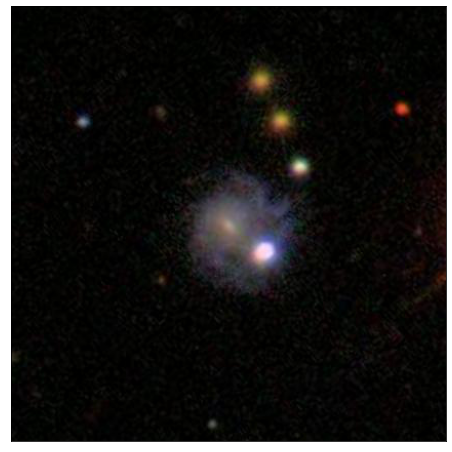

In [45]:
figure(figsize=(8,8))
idx = np.random.randint(0,len(dataset))

img, label = dataset[idx]
imshow(img)
xticks([]);
yticks([]);

### Let's visualize a batch of data

In [46]:
# Walk into the datagenerator loop, to get a single random batch
for imgs, probs in datagen:
    break
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


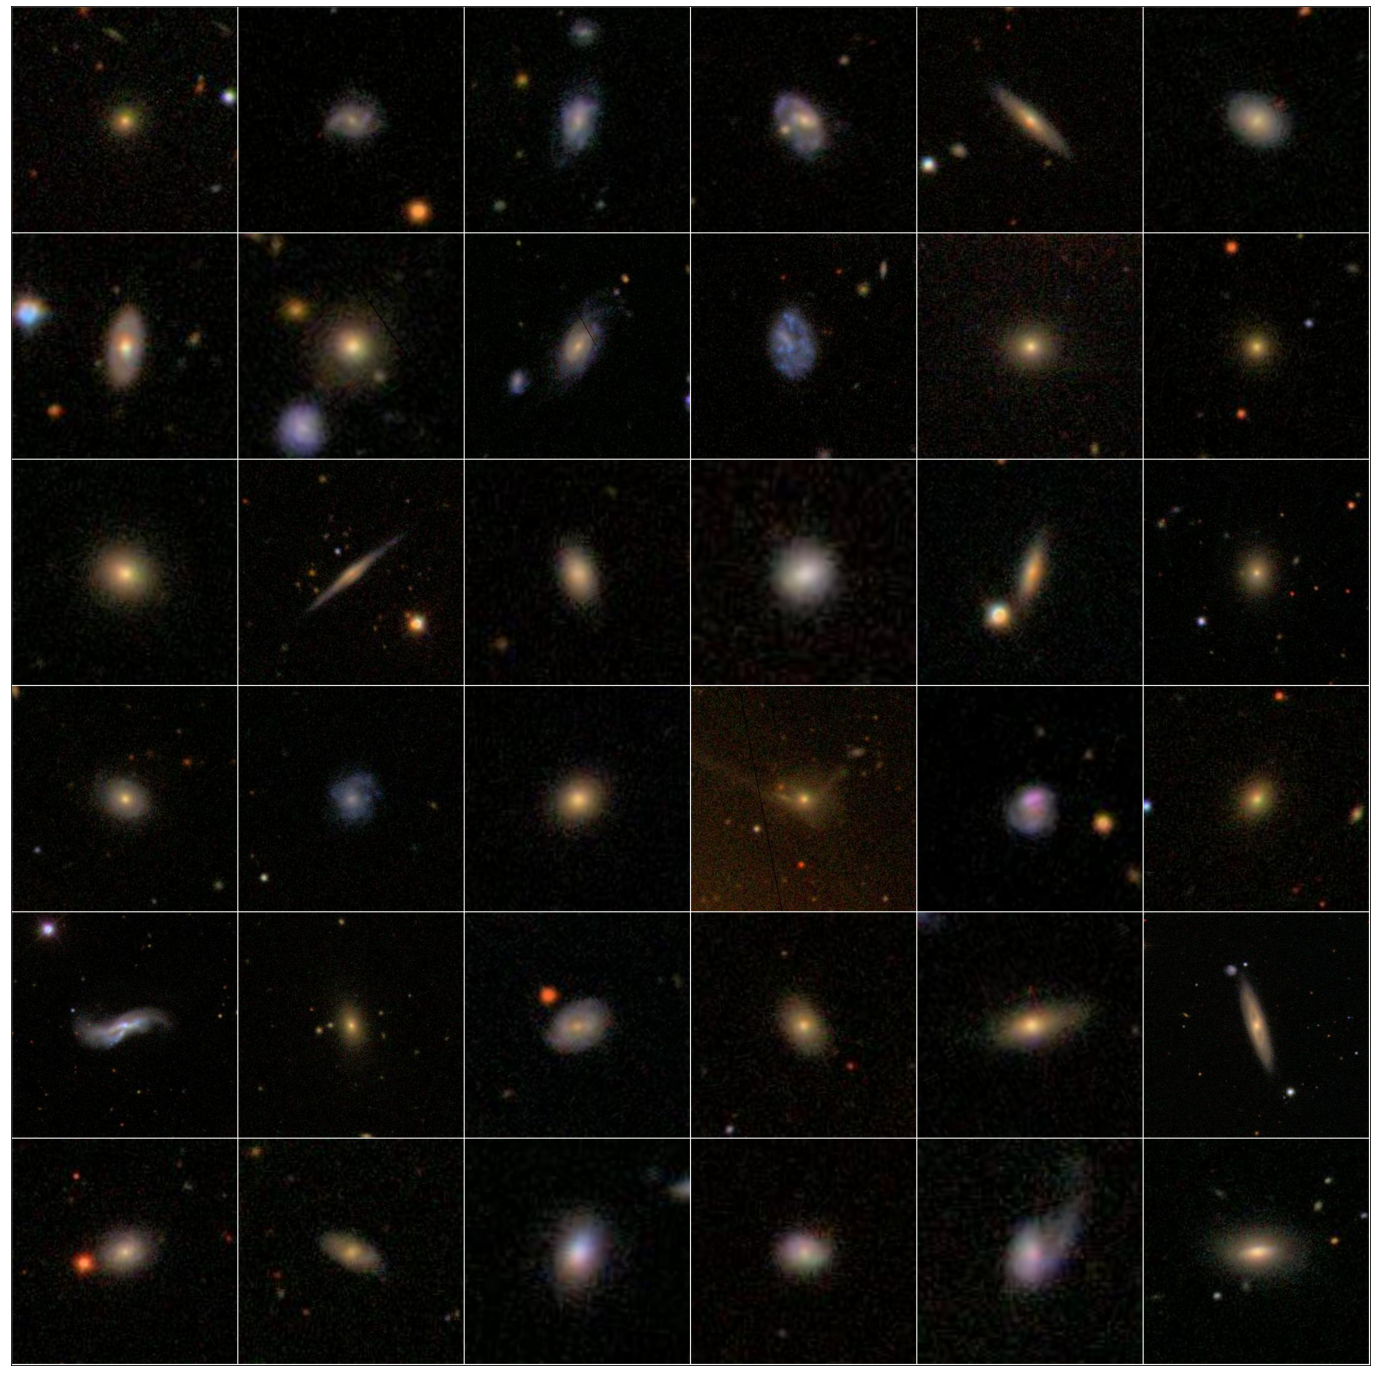

In [47]:
fig = figure(figsize=(25,25))
ax = fig.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])

temp = torchvision.utils.make_grid(imgs,nrow=6,pad_value=8).numpy().astype(np.float64)
ax.imshow(temp.transpose([1,2,0]))

## Let's see some data augmentations: 

In [83]:
transforms.RandomHorizontalFlip?

Init signature: transforms.RandomHorizontalFlip(p=0.5)
Docstring:     
Horizontally flip the given PIL Image randomly with a given probability.

Args:
    p (float): probability of the image being flipped. Default value is 0.5
File:           /usr/local/lib/python3.7/site-packages/torchvision/transforms/transforms.py
Type:           type
Subclasses:     


In [84]:
# Dataset transformations 
from torchvision import transforms
transform_train = transforms.Compose(
    [
    # Randomly crop an area, and then resize it to be 32x32
    transforms.RandomResizedCrop(400,scale=(0.2,1.)), # keep scale lower to 0.5 - 0.6 for THIS type of problem. 
    # Randomly flip the image horizontally
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # Randomly jitter the brightness, contrast and saturation of the image
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    torchvision.transforms.RandomGrayscale(p=0.1),
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    transforms.ToTensor(),
    # Normalize the image with mean and standard deviation calculated across all images
    transforms.Normalize([11.663384, 10.260227,  7.65015 ], [21.421959, 18.044296, 15.494861])
    ])

transform_test = transforms.Compose(
    [
    # Randomly crop an area, and then resize it to be 32x32
    transforms.RandomResizedCrop(400),
    transforms.ToTensor(),
    transforms.Normalize([11.663384, 10.260227,  7.65015 ], [21.421959, 18.044296, 15.494861])
    ])

dataset_train = GZooData(transform=transform_train)

### Select and index 

In [62]:
idx_vis = 19

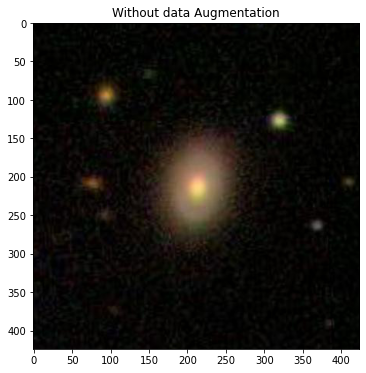

In [63]:
figure(figsize=(6,6))
img, _ = dataset[idx_vis]

imshow(img)
title("Without data Augmentation");
#xticks([])
#yticks([])

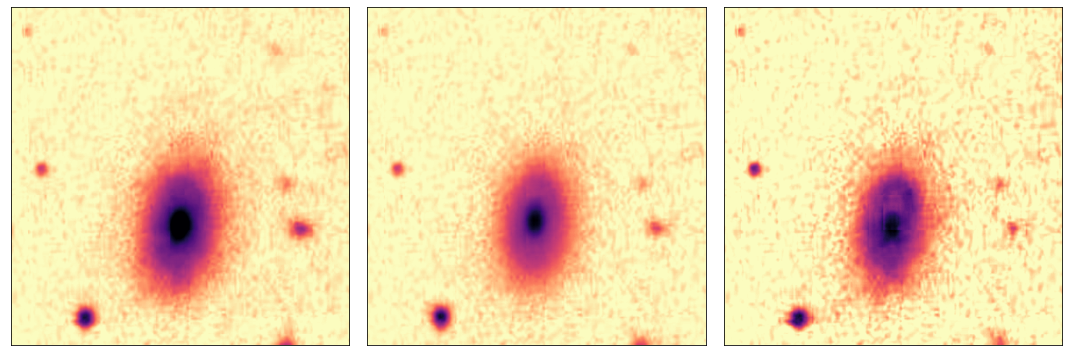

In [83]:
fig = figure(figsize=(15,5))
axs = [fig.add_subplot(1,3,i) for i in range(1,4)]

img, probs = dataset_train[idx_vis]
for i in range(3):
    axs[i].imshow(img.numpy().transpose([1,2,0])[:,:,i],cmap=cm.magma_r)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
tight_layout()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


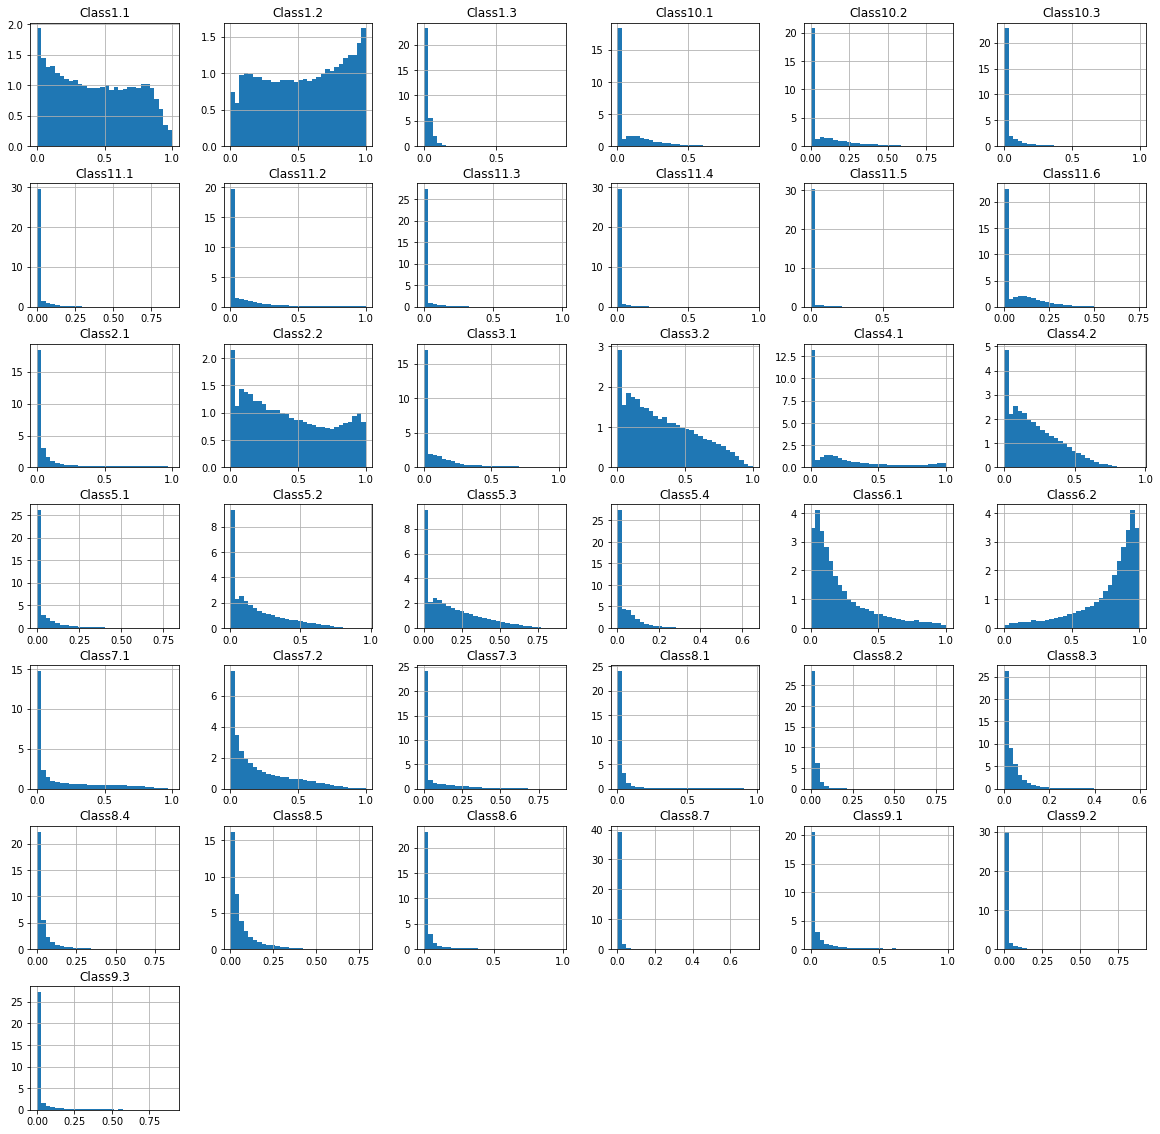

In [27]:
# Visualizing histograms of probabilities (ground truth labels)
fig = figure(figsize=(20,20))
ax = fig.add_subplot(111)

dataset[dataset.columns[1:]].hist(ax=ax,bins=30,density=True);

In [ ]:
bins=

In [ ]:

class GZooData(torch.utils.data.Dataset):
    def __init__(self, root = r'/Users/foivos/Documents/kaggle_comps/GalaxyZoo/data/'):
        
        
 